### Word2vec
<b>Word2vec</b> is a group of related models that are used to produce <b>word embeddings</b>. These models are shallow, two-layer neural networks that are trained to reconstruct linguistic contexts of words. Word2vec takes as its input a large corpus of text and produces a vector space, typically of several hundred dimensions, with each unique word in the corpus being assigned a corresponding vector in the space. Word vectors are positioned in the vector space such that words that share common contexts in the corpus are located in close proximity to one another in the space.

![](./data/images/word2vec.png "Word2Vec")

There are two ways to obtain word embeddings :

1. <b>Train your own model from scratch</b>,In this setup you start with random word vectors and learn the word vectors in the same way you learn the weights of the neural netork.
2. Load into your model word embeddings that were precomputed using a different machine-lerning task.These are called <b>pretrained word embeddings</b>.

### Types of Word2Vec
Word2Vec is one of the most widely used form of word vector representation.

It has two variants:

1. CBOW (Continuous Bag of Words) : This model tries to predict a word on bases of it’s neighbours.
2. SkipGram : This models tries to predict the neighbours of a word.

![](./data/images/CBOWvsSkipGram.png "CBOWvsSkipGram")

### Gensim

Gensim is a Python library for topic modelling, document indexing and similarity retrieval with large corpora. Gensim provides the Word2Vec class for working with a Word2Vec model.

It only requires that the input must provide sentences sequentially, when iterated over. No need to keep everything in RAM: we can provide one sentence, process it, forget it, load another sentence.

Learning a word embedding from text involves loading and organizing the text into sentences and providing them to the constructor of a new Word2Vec() instance.


There are many parameters on this constructor; a few noteworthy arguments you may wish to configure are:

* size: (default 100) The number of dimensions of the embedding, e.g. the length of the dense vector to represent each token (word).
* window: (default 5) The maximum distance between a target word and words around the target word.
* min_count: (default 5) The minimum count of words to consider when training the model; words with an occurrence less than this count will be ignored.
* workers: (default 3) The number of threads to use while training.
* sg: (default 0 or CBOW) The training algorithm, either CBOW (0) or skip gram (1).

![](./data/images/word2vec_function.png "word2vec_function")

### Importing Libraries

In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from IPython.display import Image # To view image from location/url
import keras
import nltk
STOP_WORDS = nltk.corpus.stopwords.words()
from sklearn.manifold import TSNE
import logging
import multiprocessing
import re
import os
from gensim.corpora import WikiCorpus
from gensim.models import Word2Vec
#from gensim.models.word2vec import Word2Vec
from gensim.models.word2vec import LineSentence
pd.options.mode.chained_assignment = None #set it to None to remove SettingWithCopyWarning
import time
# Input & Output files path
inputDir = "./data/"
outputDir = "./data/outDir/"
inputDir_BigFiles = "E:/BigFiles/"
outputDir_Bigfiles = "E:/BigFiles/outDir/"

### Word2Vec on Quora dataset

#### Define functions for Data Cleaning

In [80]:
def clean_sentence(val):
    "remove chars that are not letters or numbers, downcase, then remove stop words"
    regex = re.compile('([^\s\w]|_)+')
    sentence = regex.sub('', val).lower()
    sentence = sentence.split(" ")
    
    for word in list(sentence):
        if word in STOP_WORDS:
            sentence.remove(word)  
            
    sentence = " ".join(sentence)
    return sentence


def clean_dataframe(data):
    "drop nans, then apply 'clean_sentence' function to question1 and 2"
    data = data.dropna(how="any")
    
    for col in ['question1', 'question2']:
        data[col] = data[col].apply(clean_sentence)
    
    return data

#### prepare gensim-friendly data, that is iterable list of sentences

In [81]:
def build_corpus(data):
    "Creates a list of lists containing words from each sentence"
    corpus = []
    for col in ['question1', 'question2']:
        for sentence in data[col].iteritems():
            word_list = sentence[1].split(" ")
            corpus.append(word_list)
            
    return corpus

#### Function to visualise word2vec using tsne
TSNE is pretty useful when it comes to visualizing similarity between objects

In [82]:
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

#### 1. Load Quora Dateset

In [83]:
quora_dataset = pd.read_csv('./data/train.csv').sample(50000, random_state=23)
#quora_dataset = pd.read_csv('./data/train.csv')
#print(quora_dataset.shape)

#### 2. Fetch clean data(removed special characters/stopwords , drop na values)

In [84]:
tic = time.time()
quora_dataset = clean_dataframe(quora_dataset)
toc = time.time()
duration = str(round((toc -tic)))
print('Time taken to clean the dataset: '+duration+' Second(s)')
quora_dataset.head(5)

Time taken to clean the dataset: 30 Second(s)


,id,qid1,qid2,question1,question2,is_duplicate
237921,237921,9732,79801,sex necessary relationship,sex important good relationship,1
181001,181001,277377,277378,inspiring start stories,inspirational stories ever,0
294691,294691,150129,93109,best way digital marketing,best unique ways digital marketing,1
104145,104145,171986,171987,best way grow facebook fan page,get followers facebook page,1
357893,357893,487310,487311,suppose host sends two tcp segments back back ...,suppose host sends two tcp segments back back ...,1


#### 3. Build Corpus

In [85]:
corpus = build_corpus(quora_dataset)        
corpus[0:3]

[['sex', 'necessary', 'relationship'],
 ['inspiring', 'start', 'stories'],
 ['best', 'way', 'digital', 'marketing']]

#### 4. Build & Save Word2Vec model

Word2Vec parameters
* size: (default 100) The number of dimensions of the embedding, e.g. the length of the dense vector to represent each token (word).
* window: (default 5) The maximum distance between a target word and words around the target word.
* min_count: (default 5) The minimum count of words to consider when training the model; words with an occurrence less than this count will be ignored.
* workers: (default 3) The number of threads to use while training.
* sg: (default 0 or CBOW) The training algorithm, either CBOW (0) or skip gram (1).

In [86]:
quora_model = Word2Vec(corpus, size=100, window=20, min_count=250, workers=multiprocessing.cpu_count(),sg=0)
quora_model.save(outputDir+"quora_model")
size = str(round((os.path.getsize(outputDir+'quora_model')/1000),1))
print('quora_model model saved at '+outputDir+ '\nSize of file : '+size+ ' KB' )

quora_model model saved at ./data/outDir/
Size of file : 430.5 KB


#### 5. Test Quora Word2Vec model

In [87]:
quora_model.most_similar('facebook', topn=5)

[('instagram', 0.9270248413085938),
 ('delete', 0.8990750312805176),
 ('password', 0.8661477565765381),
 ('whatsapp', 0.8591115474700928),
 ('gmail', 0.8534497022628784)]

#### 6. Visualise Quora model vocab

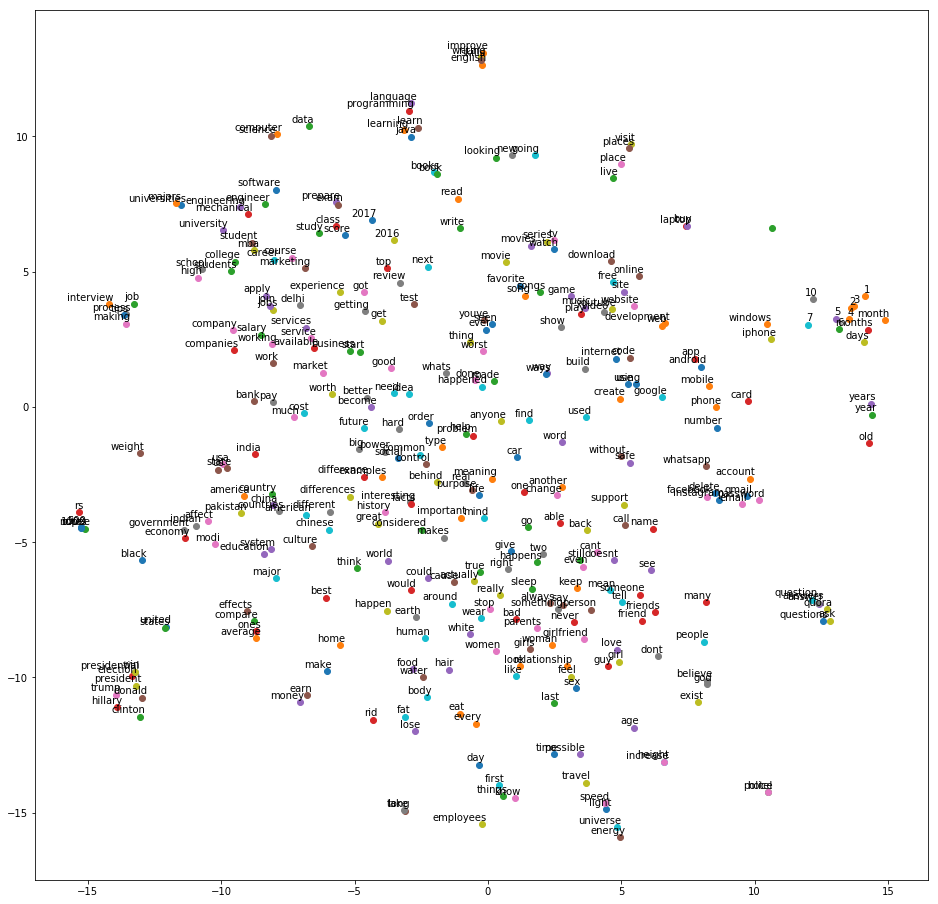

In [88]:
tsne_plot(quora_model)

### Word2Vec on Reddit dataset

#### 1. Import Reddit Dataset

In [89]:
dataset_reddit = pd.read_csv('./data/reddit-small.txt',delimiter="/t",engine='python',header=None)
dataset_reddit.head()

,0
0,one has european accent either because doesn e...
1,mid twenties male rocking skinny jeans pants h...
2,honestly wouldn have believed didn live she ma...
3,money just driver license credit cards and sub...
4,smoking tobacco went from shitty pall malls ma...


#### 2. Build & Save Word2Vec model

In [90]:
reddit_model = Word2Vec(LineSentence('./data/reddit-small.txt'),size=100, 
                        window=5,min_count=50,workers=multiprocessing.cpu_count())
reddit_model.save(outputDir+"reddit_model")
size = str(round((os.path.getsize(outputDir+'reddit_model')/1000),1))
print('reddit_model model saved at '+outputDir+ '\nSize of file : '+size+ ' KB' )

reddit_model model saved at ./data/outDir/
Size of file : 383.9 KB


#### 3. Test Reddit Word2Vec model

In [91]:
print(reddit_model.most_similar('after', topn=5))

[('girl', 0.9995027780532837), ('our', 0.9994975328445435), ('student', 0.9994271993637085), ('got', 0.999394416809082), ('went', 0.9993711709976196)]


#### 4. Visualise Reddit model vocab

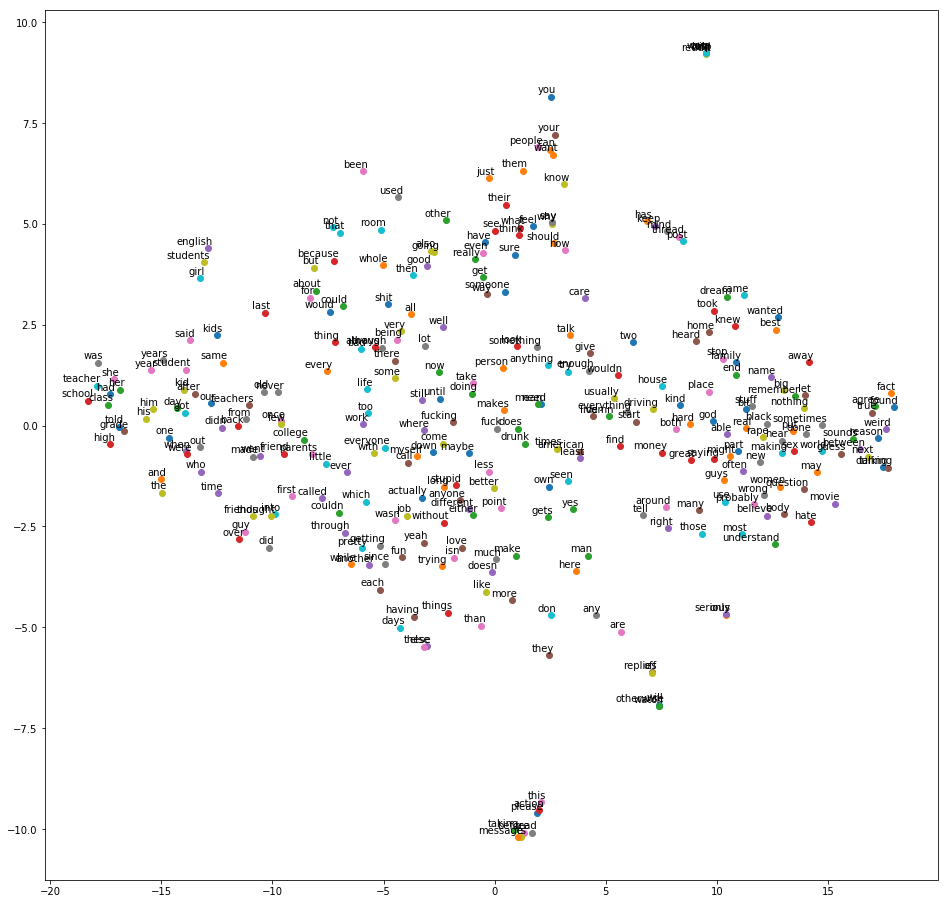

In [92]:
tsne_plot(reddit_model)